In [1]:
import os
import glob
import json
import logging
from datetime import timedelta
import dask.bag
from dask.distributed import Client
from kerchunk.netCDF3 import NetCDF3ToZarr
from kerchunk.combine import MultiZarrToZarr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
%matplotlib inline

In [2]:
savedir = 'figdata/CESM2_T0T1T2' # directory where T0, T1 and T2 data are stored 
Tsavefile = 'figdata/CESM2.TREFHT_ext_tm.nc' # file storing time mean TREFHT
Psavefile = 'figdata/CESM2.PRECT_ext_tm.nc' # file storing time mean PRECT

os.makedirs(savedir, exist_ok=True)

In [3]:
def open_mfdataset(filepaths: list[str], ncstore_dir: str='~/kerchunk', **kwargs):
    """a faster alternative to xr.open_mfdataset using kerchunk
    
    This function uses kerchunk to create an NC_STORE reference file,
    that instructs the program how to read the netCDF files efficiently. 
    Coordinates must be consistent throughout all files.
    The NC_STORE is saved after first use, and will be read on each 
    subsequent usage of this function.
    
    Parameters:
    filepaths : str or list[str]
        (list of) netCDF file names, may contain wild cards
    ncstore_dir: Pathlike
        Path where NC_STORE reference files will be saved
    kwargs: dict
        any additional keyword arguments are passed on to xr.open_dataset
        
    Returns: xr.Dataset
        a Dataset instance containing all the netCDF data
        
    v0.0
    """
    
    # make sorted list of absolute filepaths
    if isinstance(filepaths, str):
        filepaths = glob.glob(filepaths)
    filepaths = sorted([os.path.abspath(fp) for fp in filepaths])
    if len(filepaths) == 1: # use xr.open_dataset directly if there is one file
        return xr.open_dataset(filepaths[0], **kwargs)
    
    # create NC_STORE filename from netCDF filename, including timestamp
    # of first and last file. Open and return dataset if the file already exists
    ncstore_dir = os.path.expanduser(ncstore_dir)
    timestr = lambda i: os.path.basename(filepaths[i]).split('.')[-2] # timestamp
    ncstorefile = (os.path.basename(filepaths[0])
                   .replace(timestr(0),f"{timestr(0)}_{timestr(-1)}")
                   .replace('.nc','.json'))
    ncstore_path = os.path.join(ncstore_dir, ncstorefile)
    if not os.path.exists(ncstore_dir):
        os.mkdir(ncstore_dir)
    elif os.path.exists(ncstore_path):
        print(f"Reading combined kerchunk reference file {ncstore_path}")
        return xr.open_dataset(ncstore_path, **kwargs)
    
    # make new NC_STORE data
    filebag = dask.bag.from_sequence(filepaths, npartitions=None)
    reffiles = (filebag.map(NetCDF3ToZarr, inline_threshold=0, max_chunk_size=0)
                .map(lambda z: z.translate()).compute())
    mzz = MultiZarrToZarr(reffiles, concat_dims=['time'], coo_map={'time':'cf:time'})

    # set default keyword arguments for xr.open_dataset on NC_STORE file
    default_kw = {'engine':'kerchunk', 'storage_options':{'target_protocol':'file'}}
    for (k,v) in default_kw.items():
        if k in kwargs:
            print(f'open_mfdataset(): ignoring keyword {k}')
        kwargs[k] = v
    
    # write NC_STORE data and return opened dataset
    with open(f"{ncstore_path}", "wb") as f:
       print(f"Writing combined kerchunk reference file {ncstore_path}")
       f.write(json.dumps(mzz.translate()).encode())
    
    return xr.open_dataset(ncstore_path, **kwargs)


def wmean(arr, w, *args, **kwargs):
    """Wrapper for DataArray.weighted.mean to restore coordinate attributes"""
    wmean = arr.weighted(w).mean(*args, **kwargs)
    return wmean.assign_coords({k:arr[k] for k in wmean.coords})


def T0_T1_T2(ds):
    """Calculate T0, T1, T2 and return as dict"""
    sinlat = np.sin(np.deg2rad(ds.lat))
    dims = ('lat','lon')
    T0data = wmean(ds.TREFHT, ds.gw, dims).compute()
    T1data = wmean(ds.TREFHT*sinlat, ds.gw, dims).compute()
    T2data = wmean(ds.TREFHT*(3*sinlat**2-1), ds.gw, dims).compute()
    return {'T0':T0data, 'T1':T1data, 'T2':T2data}


def ListedColorMap(cmap, N, white=False):
    """Create a listed colormap for filled contours with N levels"""
    if isinstance(cmap, str):
        cmap = mpl.colormaps[cmap]
    new_colors = cmap(np.linspace(0,1,N+1))
    if white:
        new_colors[int(np.floor((N)/2))] = [1,1,1,1]
        new_colors[int(np.ceil((N)/2))] = [1,1,1,1]
    new_cmap = mpl.colors.ListedColormap(new_colors[1:-1])
    new_cmap.set_over(new_colors[-1])
    new_cmap.set_under(new_colors[0])
    return new_cmap

### Calculations
Results are stored so this section may be skipped.

In [4]:
# CAM output files
FILES = {
    'control': sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.control.01/atm/hist/*.h0.*.nc"))
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.control.06/atm/hist/*.h0.*.nc")),
    'SAI2020': sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.01/atm/hist/*.h0.*.nc"))[0:300] # 2020-2044
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.02/atm/hist/*.h0.*.nc"))[:-12] # 2045-2099
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.02_ext02/atm/hist/*.h0.*.nc")), # 2100-2130
    'SAI2080': sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.feedback.09/atm/hist/*.h0.*.nc"))
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2080feedback_ext01/atm/hist/*.h0.*.nc"))
}

# WACCM output files
WACFILES = {
    'control': '/home/jasperdj/simone/CMIP6/tas/tas.Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc',
    'SAI2020': ['/home/jasperdj/simone/GLENS/b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM.feedback.15C.001.cam.h0.TREFHT.201901-206812.nc',
                '/home/jasperdj/simone/GLENS/b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM.feedback.15C.001.cam.h0.TREFHT.206901-210012.nc'],
}

In [5]:
%%time
cam = {k:open_mfdataset(v, chunks={'time':1}) for k,v in FILES.items()} # open datasets

Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e21.BSSP585cmip6.f09_g17.control.01.cam.h0.2015-01_2130-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e21.BSSP585cmip6.f09_g17.2020feedback.01.cam.h0.2020-01_2130-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e21.BSSP585cmip6.f09_g17.2080feedback_ext01.cam.h0.2100-01_2099-12.json
CPU times: user 12.2 s, sys: 1.09 s, total: 13.3 s
Wall time: 13.7 s


In [6]:
waccm = {k:xr.open_mfdataset(v) for k,v in WACFILES.items()}
waccm['control'] = waccm['control'].rename({'tas':'TREFHT'})
waccm['control']['gw'] = waccm['SAI2020'].gw.isel(time=0)

/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tas' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [7]:
# set time to center of time_bnds
dt = timedelta(days=15, hours=12)
for k,v in cam.items():
    cam[k] = v.assign_coords(time=('time', v.time.data-dt, v.time.attrs))
    # cam[k] = v.assign_coords(time=('time',v.time_bnds.mean('nbnd').data,v.time.attrs)) # this does not work because time_bnds is messy on parts of the data

for k,v in waccm.items():
    waccm[k] = v.assign_coords(time=('time', v.time.data-dt, v.time.attrs))

In [8]:
# # Check to see if the reference period is OK

# logfile = '../controller/logs/ControlLog_b.e21.BSSP585cmip6.f09_g17.2020feedback.02.2020-2100.txt'

# with open(logfile) as f:
#     lines = f.readlines()
    
# dT0_log = xr.DataArray(
#     [float(line.split(' ')[1]) for line in lines[1:]],
#     coords={'year':[int(line.split(' ')[0]) for line in lines[1:]]},
#     dims = ('year'))

# T0 = {tag: wmean(cam[tag].TREFHT, cam[tag].gw, ('lat','lon')).compute() for tag in cam}
# T0 = {k:v.coarsen(time=12).mean() for k,v in T0.items()}

# T0_ref = T0['control'].isel(time=slice(1,21)).mean('time') # ref is 2016-2035 avg of control

# dT0_log.plot(label='dT0 log')
# (T0['SAI2020'].assign_coords(year=T0['SAI2020'].time.dt.year)-T0_ref).plot(label='dT0', x='year')
# plt.legend()

In [9]:
%%time
# Calculate annual mean T0, T1 and T2 for CAM

T_cam = {}
for exp in cam:
    T_cam[exp] = T0_T1_T2(cam[exp])
    T_cam[exp] = {k:v.coarsen(time=12).mean() for k,v in T_cam[exp].items()}

# prepend last year of control before branching to SAI2080
for grad in T_cam['SAI2080']:
    T_cam['SAI2080'][grad] = xr.concat((T_cam['control'][grad].sel(time='2079'), T_cam['SAI2080'][grad]), dim='time')

CPU times: user 1min 49s, sys: 1min 25s, total: 3min 15s
Wall time: 1min 53s


In [10]:
%%time
# Calculate annual mean T0, T1 and T2 for WACCM

T_waccm = {}
for exp in waccm:
    T_waccm[exp] = T0_T1_T2(waccm[exp])
    T_waccm[exp] = {k:v.coarsen(time=12).mean() for k,v in T_waccm[exp].items()}

CPU times: user 26.3 s, sys: 1.59 s, total: 27.9 s
Wall time: 19 s


In [11]:
# save T0, T1 and T2 data

for dsi,tag in zip((T_waccm, T_cam), ('WACCM','CAM')):
    for exp in dsi:
        dsii = xr.Dataset(
            {'T0':dsi[exp]['T0'], 'T1':dsi[exp]['T1'], 'T2':dsi[exp]['T2']},
            coords={'time':dsi[exp]['T0'].time},
            attrs={'description':f'T0, T1 and T2 for {tag} {exp}.'},
        )
        fname = os.path.join(savedir,f'{tag}.{exp}.nc')
        if os.path.exists(fname): # prevent overwriting
            print(f"{os.path.basename(fname)} already exists")
        else:
            dsii.to_netcdf(fname)
            print(f"saved {fname}")

WACCM.control.nc already exists
WACCM.SAI2020.nc already exists
CAM.control.nc already exists
CAM.SAI2020.nc already exists
CAM.SAI2080.nc already exists


In [12]:
%%time
var = 'TREFHT' # ['TREFHT','PRECT']
fname = {'TREFHT': Tsavefile,'PRECT': Psavefile}[var]
tslice1 = slice('2016','2035')
tslice2 = slice('2100','2130')

VAR = {
    'Reference': cam['control'][var].sel(time=tslice1).mean('time'),
    'Control': cam['control'][var].sel(time=tslice2).mean('time'),
    'SAI2020': cam['SAI2020'][var].sel(time=tslice2).mean('time'),
    'SAI2080': cam['SAI2080'][var].sel(time=tslice2).mean('time')
}

ds = xr.Dataset(VAR, coords=VAR['Reference'].coords)
ds.to_netcdf(fname)
print(f'saved {fname}')

saved figdata/CESM2.TREFHT_ext_tm.nc
CPU times: user 7.11 s, sys: 6.09 s, total: 13.2 s
Wall time: 6.98 s


### Plotting

In [16]:
slice_i = slice('2016','2035')
slice_f = slice('2080','2099')
slice_e = slice('2100','2130')

In [4]:
# load T0, T1 & T2 data 

files = glob.glob(os.path.join(savedir, "WACCM.*.nc"))
T_waccm = {file.split('.')[1]: xr.open_dataset(file) for file in files}

files = glob.glob(os.path.join(savedir, "CAM.*.nc"))
T_cam = {file.split('.')[1]: xr.open_dataset(file) for file in files}

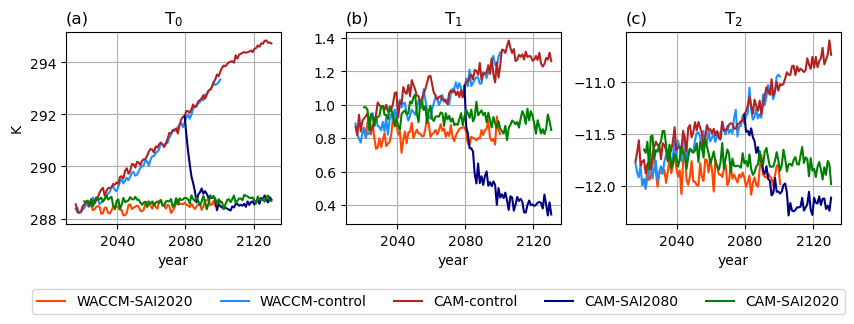

In [14]:
cols = ['firebrick','navy','green']
colsW = ['orangered','dodgerblue']
labels = list(T_cam.keys())
fig, ax = plt.subplots(1,3, figsize=(10,2.5), sharex=True)

# T0 plot
for e,exp in enumerate(T_waccm):
    (T_waccm[exp]['T0']).plot(ax=ax[0], label='WACCM-'+exp, c=colsW[e])   
for e,exp in enumerate(T_cam):
    (T_cam[exp]['T0']).plot(ax=ax[0], label='CAM-'+exp, c=cols[e])

# T1 plot
for e,exp in enumerate(T_waccm):
    (T_waccm[exp]['T1']).plot(ax=ax[1], label=exp, c=colsW[e])  
for e,exp in enumerate(T_cam):
    (T_cam[exp]['T1']).plot(ax=ax[1], label=labels[e], c=cols[e])

# T2 plot
for e,exp in enumerate(T_waccm):
    (T_waccm[exp]['T2']).plot(ax=ax[2], label=exp, c=colsW[e])  
for e,exp in enumerate(T_cam):
    (T_cam[exp]['T2']).plot(ax=ax[2], label=labels[e], c=cols[e])

ax[0].set_title(r'T$_0$'); ax[0].set_title('(a)', loc='left')
ax[1].set_title(r'T$_1$'); ax[1].set_title('(b)', loc='left')
ax[2].set_title(r'T$_2$'); ax[2].set_title('(c)', loc='left')
ax[0].set_ylabel('K')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[0].legend(prop={'size':10}, bbox_to_anchor=(3.65, -0.3), ncols=5)
for axi in ax:
    axi.grid()
    axi.set_xlabel('year')
plt.subplots_adjust(wspace=0.3)
fig.savefig('figures/T0_T1_T2.abs.pdf', bbox_inches='tight')

Reference values CAM [2016--2035] WACCM [2015--2024]
T0: {'cam': 288.7204767466707, 'waccm': 288.41956331170366}
T1: {'cam': 0.9322644721005732, 'waccm': 0.8370044827034816}
T2: {'cam': -11.698897384592788, 'waccm': -11.885540304295176}
Control values CAM [2080--2099]
T0: 292.6874734947337
T1: 1.1886833766545273
T2: -11.15891074171137
SAI2020 values CAM [2080--2099]
T0: 288.70431662668005
T1: 0.9307371347660363
T2: -11.768326397462822
Control values CAM [2100--2130]
T0: 294.3460999292409
T1: 1.2921160886893464
T2: -10.847047422900323
SAI2080 values CAM [2100--2130]
T0: 288.56704227352753
T1: 0.41209611491727394
T2: -12.160996431739047


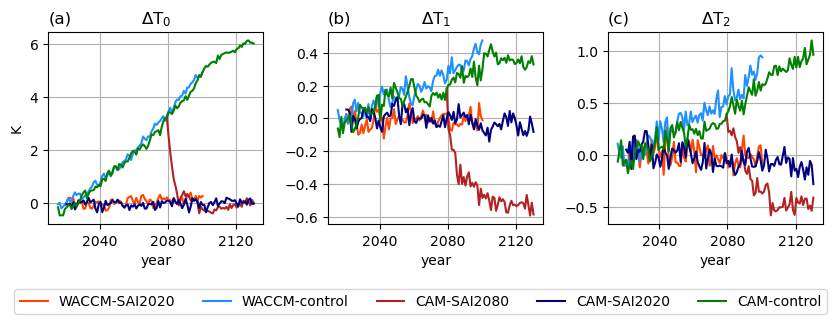

In [22]:
cols = ['firebrick','navy','green']
colsW = ['orangered','dodgerblue']
labels = list(T_cam.keys())
fig, ax = plt.subplots(1,3, figsize=(10,2.5), sharex=True)

T0ref = {'cam': T_cam['control']['T0'].isel(time=slice(1,21)).mean('time').item(),
         'waccm': T_waccm['control']['T0'].isel(time=slice(0,10)).mean('time').item()}
T1ref = {'cam': T_cam['control']['T1'].isel(time=slice(1,21)).mean('time').item(),
         'waccm': T_waccm['control']['T1'].isel(time=slice(0,10)).mean('time').item()}
T2ref = {'cam': T_cam['control']['T2'].isel(time=slice(1,21)).mean('time').item(),
         'waccm': T_waccm['control']['T2'].isel(time=slice(0,10)).mean('time').item()}

print("Reference values CAM [2016--2035] WACCM [2015--2024]")
for k,v in {'T0':T0ref, 'T1':T1ref, 'T2':T2ref}.items():
    print(f"{k}: {v}")
print("Control values CAM [2080--2099]")
for k,v in {'T0':T_cam['control']['T0'], 'T1':T_cam['control']['T1'], 'T2':T_cam['control']['T2']}.items():
    print(f"{k}: {v.sel(time=slice_f).mean('time').item()}")
print("SAI2020 values CAM [2080--2099]")
for k,v in {'T0':T_cam['SAI2020']['T0'], 'T1':T_cam['SAI2020']['T1'], 'T2':T_cam['SAI2020']['T2']}.items():
    print(f"{k}: {v.sel(time=slice_f).mean('time').item()}")
print("Control values CAM [2100--2130]")
for k,v in {'T0':T_cam['control']['T0'], 'T1':T_cam['control']['T1'], 'T2':T_cam['control']['T2']}.items():
    print(f"{k}: {v.sel(time=slice_e).mean('time').item()}")
print("SAI2080 values CAM [2100--2130]")
for k,v in {'T0':T_cam['SAI2080']['T0'], 'T1':T_cam['SAI2080']['T1'], 'T2':T_cam['SAI2080']['T2']}.items():
    print(f"{k}: {v.sel(time=slice_e).mean('time').item()}")

# T0 plot
for e,exp in enumerate(T_waccm):
    (T_waccm[exp]['T0']-T0ref['waccm']).plot(ax=ax[0], label='WACCM-'+exp, c=colsW[e])   
for e,exp in enumerate(T_cam):
    (T_cam[exp]['T0']-T0ref['cam']).plot(ax=ax[0], label='CAM-'+exp, c=cols[e])

# T1 plot
for e,exp in enumerate(T_waccm):
    (T_waccm[exp]['T1']-T1ref['waccm']).plot(ax=ax[1], label=exp, c=colsW[e])  
for e,exp in enumerate(T_cam):
    (T_cam[exp]['T1']-T1ref['cam']).plot(ax=ax[1], label=labels[e], c=cols[e])

# T2 plot
for e,exp in enumerate(T_waccm):
    (T_waccm[exp]['T2']-T2ref['waccm']).plot(ax=ax[2], label=exp, c=colsW[e])  
for e,exp in enumerate(T_cam):
    (T_cam[exp]['T2']-T2ref['cam']).plot(ax=ax[2], label=labels[e], c=cols[e])

ax[0].set_title(r'$\Delta$T$_0$'); ax[0].set_title('(a)', loc='left')
ax[1].set_title(r'$\Delta$T$_1$'); ax[1].set_title('(b)', loc='left')
ax[2].set_title(r'$\Delta$T$_2$'); ax[2].set_title('(c)', loc='left')
ax[0].set_ylabel('K')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[0].legend(prop={'size':10}, bbox_to_anchor=(3.65, -0.3), ncols=5)
for axi in ax:
    axi.grid()
    axi.set_xlabel('year')
plt.subplots_adjust(wspace=0.3)

# fig.savefig('figures/T0_T1_T2.pdf', bbox_inches='tight')

(-0.5, 1.0)

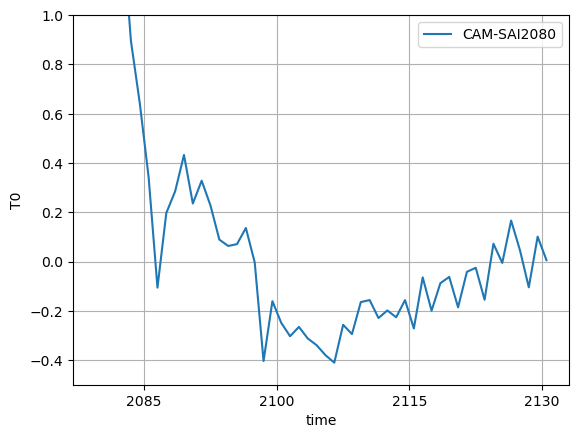

In [21]:
(T_cam['SAI2080']['T0']-T0ref['cam']).plot(label='CAM-SAI2080')
plt.legend()
plt.grid()
plt.ylim([-0.5,1])

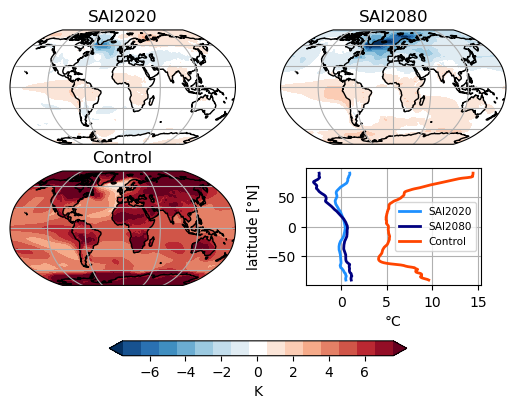

In [16]:
ds = xr.open_dataset(Tsavefile)

da1 = ds['SAI2020'] - ds['Reference']
da2 = ds['SAI2080'] - ds['Reference']
da3 = ds['Control'] - ds['Reference']
da4 = {'SAI2020':da1.mean('lon'), 'SAI2080':da2.mean('lon'), 'control':da3.mean('lon')}

cmap = ListedColorMap('RdBu_r', 16, white=True)
cfkwargs = {'transform':ccrs.PlateCarree(), 'levels':np.linspace(-7.5,7.6,16), 'extend':'both', 'cmap':cmap, 'add_colorbar':False}
cols = ['dodgerblue','navy','orangered']
fig, axs = plt.subplots(2,2, subplot_kw={'projection':ccrs.Robinson()})
fig.delaxes(axs[1,1])
axs[1,1] = fig.add_subplot(2,2,4, aspect=0.065)

p1 = da1.plot.contourf(ax=axs[0,0], **cfkwargs)
p2 = da2.plot.contourf(ax=axs[0,1], **cfkwargs)
p3 = da3.plot.contourf(ax=axs[1,0], **cfkwargs)
for i,(k,v) in enumerate(da4.items()):
    v.plot(ax=axs[1,1], y='lat', label=k.replace('control','Control'), c=cols[i], lw=2)

axs[0,0].set_title('SAI2020') 
axs[0,1].set_title('SAI2080')
axs[1,0].set_title('Control')    
axs[1,1].set_xlabel('°C')
axs[1,1].set_ylabel('latitude [°N]')
axs[1,1].grid()
axs[1,1].legend(prop={'size':7.5})

for ax in axs.flatten()[:3]:
    ax.gridlines()
    ax.coastlines()

cb = fig.colorbar(p2, ax=list(axs.ravel()), orientation='horizontal', shrink=.6)
cb.ax.set_xticks(range(-6,7,2))
cb.ax.set_xticks([], minor=True)
cb.ax.set_xlabel('K')
#fig.suptitle(rf"$\Delta$T ({tslice2.start}-{tslice2.stop}) - ({tslice1.start}-{tslice1.stop})")
fig.savefig('figures/TREFHT.SAIandCNT-REF.ext.pdf', bbox_inches='tight')